# Notebook for Run Training

## Import module

In [3]:
import pickle
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run
from neuralhydrology.utils.nh_results_ensemble import create_results_ensemble
from neuralhydrology.nh_run_scheduler import schedule_runs
from neuralhydrology.evaluation.plots import percentile_plot, regression_plot, uncertainty_plot

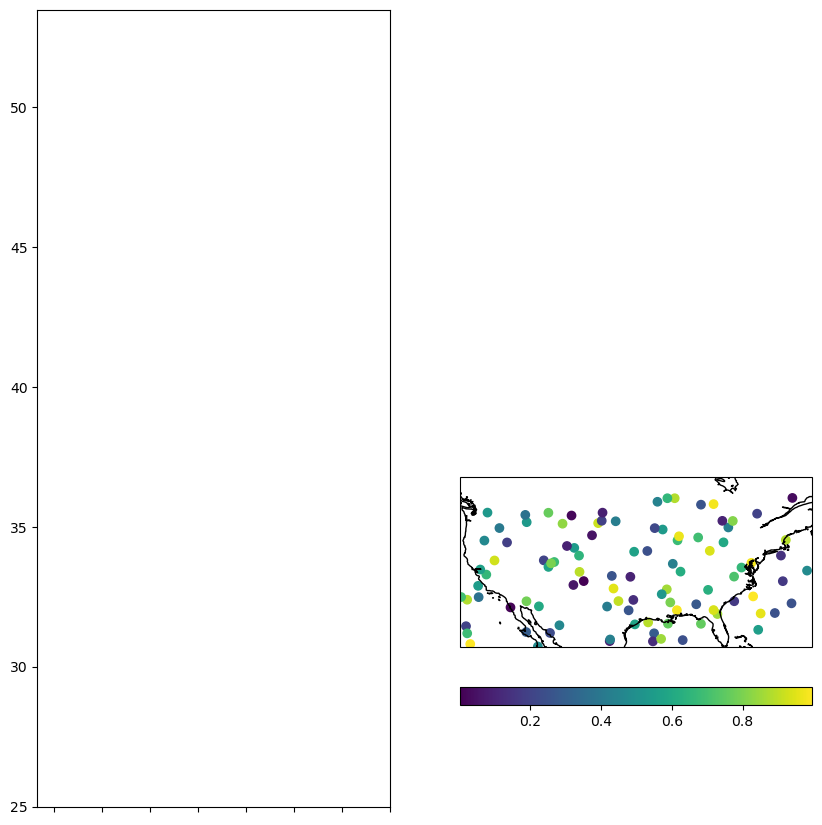

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

# Sample data - replace with your actual data
lons = np.random.uniform(-125, -66, size=100)
lats = np.random.uniform(25, 50, size=100)
nse_values = np.random.uniform(0, 1, size=100)

# Load the shapefile
# shapefile_path = "shapefile/HUC Boundary.shp"
# gdf = gpd.read_file(shapefile_path)

# Create figure and axes
fig = plt.figure(figsize=(10, 14))
grid = plt.GridSpec(4, 2, wspace=0.2, hspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1], projection=ccrs.PlateCarree())
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)

# Draw the map with cartopy
main_ax.set_extent([-125, -66, 25, 50])
main_ax.coastlines()

# Plot the shapefile
# gdf.plot(ax=main_ax, facecolor='none', edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())

# Scatter plot on the map
scatter = main_ax.scatter(lons, lats, c=nse_values, cmap='viridis', transform=ccrs.PlateCarree())

# Histogram on the y-axis
y_hist.hist(nse_values, bins=30, orientation='horizontal', color='gray')
y_hist.invert_xaxis()

# Colorbar
plt.colorbar(scatter, ax=main_ax, orientation='horizontal', pad=0.05)

plt.show()


In [7]:
# Load the shapefile
shapefile_path = "shapefile/HUC Boundary.shp"
gdf = gpd.read_file(shapefile_path)

# Plot the shapefile
gdf.plot(ax=main_ax, facecolor='none', edgecolor='red', linewidth=2, transform=ccrs.PlateCarree())

<GeoAxes: >

<Figure size 640x480 with 0 Axes>

## Training Model

1. Base Model = LSTM without dropout rate
2. MCD Model = LSTM with Regression head, Monte Carlo Dropout, and dropout rate
3. UMAL Model = LSTM with UMAL head and dropout rate

### Base Model

In [ ]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("base_model_cudalstm.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("base_model_cudalstm.yml"), gpu=-1)

### MCD Model

In [ ]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("mcd_model_cudalstm.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("mcd_model_cudalstm.yml"), gpu=-1)

### UMAL Model

In [ ]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
if torch.cuda.is_available():
    start_run(config_file=Path("umal_model_cudalstm.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("umal_model_cudalstm.yml"), gpu=-1)

## Evaluate run on test set
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [5]:
# Probabilistic model 1
run_dir = Path("run_cudalstm_gmm_model")
eval_run(run_dir=run_dir, period="test")

# Evaluation: 100%|████████████████████████████████████████████████████████████████████| 91/91 [00:55<00:00,  1.64it/s]


In [ ]:
# # Probabilistic model 2
# run_dir2 = Path("run_cudalstm_gmm_model_250")
# eval_run(run_dir=run_dir2, period="test")

### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [7]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['10396000', '12010000', '12013500', '12020000', '12025000', '12025700', '12035000', '12040500', '12041200', '12043000', '12048000', '12054000', '12056500', '12073500', '12082500', '12092000', '12095000', '12114500', '12115000', '12115500', '12117000', '12141300', '12143600', '12144000', '12145500', '12147500', '12147600', '12167000', '12175500', '12178100', '12186000', '12189500', '12358500', '12374250', '12375900', '12377150', '12381400', '12383500', '12388400', '12390700', '12411000', '12414500', '12447390', '12451000', '12488500', '13011500', '13011900', '13018300', '13023000', '13083000', '13161500', '13235000', '13240000', '13310700', '13313000', '13331500', '13337000', '13338500', '13340000', '13340600', '14020000', '14092750', '14096850', '14137000', '14138800', '14138870', '14138900', '14139800', '14141500', '14154500', '14158500', '14158790', '14166500', '14182500', '14185000', '14185900', '14187000', '14216500', '14222500', '14236200', '14301000', '14303200', '1430

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [8]:
# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results.keys():
    # For each dataset in the dictionary
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    dataset['QObs(mm/d)_sim_mean'] = dataset['QObs(mm/d)_sim'].mean(dim='samples')
    dataset['QObs(mm/d)_sim_median'] = dataset['QObs(mm/d)_sim'].median(dim='samples')
    # Select data up to and including 31st December 2008
    results[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

In [9]:
# Calculate all metrics for each basin using mean and median results of probabilistic forecasting
for key in results.keys():
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    
    # Extract observed data
    qobs = dataset['QObs(mm/d)_obs'].isel(time_step=-1)
    # Extract mean and median simulated data
    qsim_mean = dataset['QObs(mm/d)_sim_mean'].isel(time_step=-1)
    qsim_median = dataset['QObs(mm/d)_sim_median'].isel(time_step=-1)

    # Calculate metrics for mean simulated data
    mean_metrics = metrics.calculate_all_metrics(qobs, qsim_mean)
    # Store mean metrics in the dictionary
    results[key]['1D']['mean_metrics'] = mean_metrics

    # Calculate metrics for median simulated data
    median_metrics = metrics.calculate_all_metrics(qobs, qsim_median)
    # Store median metrics in the dictionary
    results[key]['1D']['median_metrics'] = median_metrics

In [10]:
from collections import defaultdict

# Initialize dictionaries to store the sum of metrics
sum_mean_metrics = defaultdict(float)
sum_median_metrics = defaultdict(float)
num_basins = len(results)

# Iterate over each key (basin) in results
for key in results.keys():
    # Retrieve mean_metrics and median_metrics directly from the dictionary
    if 'mean_metrics' in results[key]['1D'] and 'median_metrics' in results[key]['1D']:
        mean_metrics = results[key]['1D']['mean_metrics']
        median_metrics = results[key]['1D']['median_metrics']

        # Sum the metrics for each basin
        for metric, value in mean_metrics.items():
            sum_mean_metrics[metric] += value
        for metric, value in median_metrics.items():
            sum_median_metrics[metric] += value

# Calculate the average for mean_metrics and median_metrics
average_mean_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_mean_metrics.items()}
average_median_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_median_metrics.items()}

In [11]:
# Print the average metrics
print("Average of Mean-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_mean_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

print("\nAverage of Median-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_median_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

Average of Mean-Probf vs One-Point Metrics Across All Basins:
NSE: 0.319
MSE: 24.382
RMSE: 3.881
KGE: 0.292
Alpha-NSE: 0.486
Beta-KGE: 1.070
Beta-NSE: 0.058
Pearson-r: 0.879
FHV: -50.219
FMS: -45.108
FLV: 60.363
Peak-Timing: 0.585
Peak-MAPE: 56.632

Average of Median-Probf vs One-Point Metrics Across All Basins:
NSE: 0.312
MSE: 25.466
RMSE: 3.979
KGE: 0.277
Alpha-NSE: 0.461
Beta-KGE: 1.038
Beta-NSE: 0.034
Pearson-r: 0.878
FHV: -52.440
FMS: -46.133
FLV: 60.401
Peak-Timing: 0.565
Peak-MAPE: 58.049


Let's plot the model predictions vs. the observations

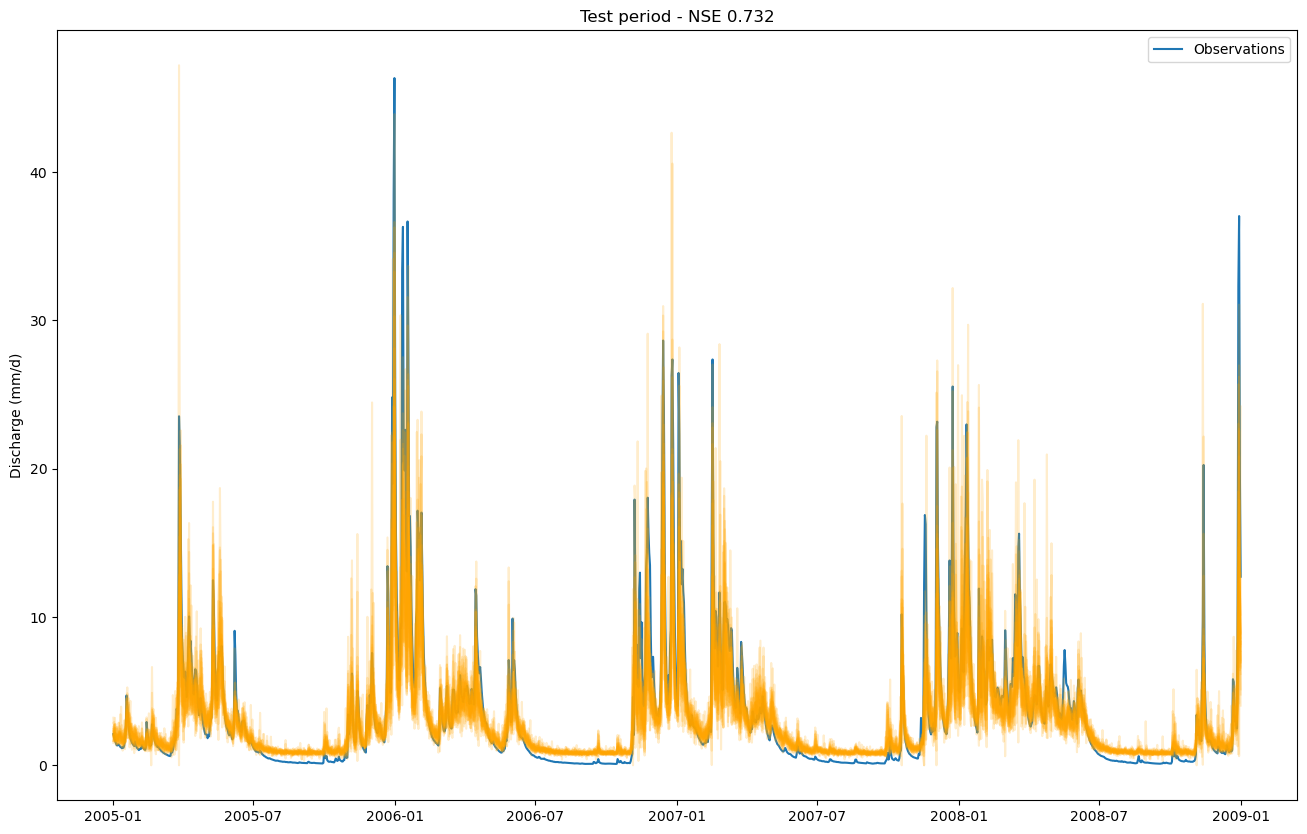

In [12]:
# Extract observations and simulations
qobs = results['14187000']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['14187000']['1D']['xr']['QObs(mm/d)_sim']

# Plot observations
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(qobs['date'], qobs, label='Observations')

# Plot all simulation samples
for i in range(qsim.shape[2]):
    ax.plot(qsim['date'], qsim.isel(samples=i), color='orange', alpha=0.2, label='_nolegend_')  # Plot each sample with low alpha for transparency

ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['14187000']['1D']['NSE']:.3f}")
ax.legend()
plt.show()


In [13]:
# Preprocess result before evaluation
qsim_pi = qsim.values.swapaxes(0, 2).squeeze()
qobs_pi = qobs.values.squeeze()

In [14]:
# Evaluation metrics for probabilistic forecasting
metrics.calculate_all_metrics_prob(qobs_pi,qsim_pi,95)

{'PINAW': 0.5827288579643893, 'PICP': 46.54346338124572}

In [15]:
# Probabilistic model 2
run_dir2 = Path("run_cudalstm_gmm_model_250")
eval_run(run_dir=run_dir2, period="test")

# Evaluation: 100%|████████████████████████████████████████████████████████████████████| 91/91 [01:05<00:00,  1.39it/s]


In [24]:
with open(run_dir2 / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['10396000', '12010000', '12013500', '12020000', '12025000', '12025700', '12035000', '12040500', '12041200', '12043000', '12048000', '12054000', '12056500', '12073500', '12082500', '12092000', '12095000', '12114500', '12115000', '12115500', '12117000', '12141300', '12143600', '12144000', '12145500', '12147500', '12147600', '12167000', '12175500', '12178100', '12186000', '12189500', '12358500', '12374250', '12375900', '12377150', '12381400', '12383500', '12388400', '12390700', '12411000', '12414500', '12447390', '12451000', '12488500', '13011500', '13011900', '13018300', '13023000', '13083000', '13161500', '13235000', '13240000', '13310700', '13313000', '13331500', '13337000', '13338500', '13340000', '13340600', '14020000', '14092750', '14096850', '14137000', '14138800', '14138870', '14138900', '14139800', '14141500', '14154500', '14158500', '14158790', '14166500', '14182500', '14185000', '14185900', '14187000', '14216500', '14222500', '14236200', '14301000', '14303200', '1430

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [25]:
# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results.keys():
    # For each dataset in the dictionary
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    dataset['QObs(mm/d)_sim_mean'] = dataset['QObs(mm/d)_sim'].mean(dim='samples')
    dataset['QObs(mm/d)_sim_median'] = dataset['QObs(mm/d)_sim'].median(dim='samples')
    # Select data up to and including 31st December 2008
    results[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

In [26]:
# Calculate all metrics for each basin using mean and median results of probabilistic forecasting
for key in results.keys():
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    
    # Extract observed data
    qobs = dataset['QObs(mm/d)_obs'].isel(time_step=-1)
    # Extract mean and median simulated data
    qsim_mean = dataset['QObs(mm/d)_sim_mean'].isel(time_step=-1)
    qsim_median = dataset['QObs(mm/d)_sim_median'].isel(time_step=-1)

    # Calculate metrics for mean simulated data
    mean_metrics = metrics.calculate_all_metrics(qobs, qsim_mean)
    # Store mean metrics in the dictionary
    results[key]['1D']['mean_metrics'] = mean_metrics

    # Calculate metrics for median simulated data
    median_metrics = metrics.calculate_all_metrics(qobs, qsim_median)
    # Store median metrics in the dictionary
    results[key]['1D']['median_metrics'] = median_metrics

In [27]:
from collections import defaultdict

# Initialize dictionaries to store the sum of metrics
sum_mean_metrics = defaultdict(float)
sum_median_metrics = defaultdict(float)
num_basins = len(results)

# Iterate over each key (basin) in results
for key in results.keys():
    # Retrieve mean_metrics and median_metrics directly from the dictionary
    if 'mean_metrics' in results[key]['1D'] and 'median_metrics' in results[key]['1D']:
        mean_metrics = results[key]['1D']['mean_metrics']
        median_metrics = results[key]['1D']['median_metrics']

        # Sum the metrics for each basin
        for metric, value in mean_metrics.items():
            sum_mean_metrics[metric] += value
        for metric, value in median_metrics.items():
            sum_median_metrics[metric] += value

# Calculate the average for mean_metrics and median_metrics
average_mean_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_mean_metrics.items()}
average_median_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_median_metrics.items()}

In [28]:
# Print the average metrics
print("Average of Mean-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_mean_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

print("\nAverage of Median-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_median_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

Average of Mean-Probf vs One-Point Metrics Across All Basins:
NSE: 0.795
MSE: 10.175
RMSE: 2.452
KGE: 0.807
Alpha-NSE: 0.933
Beta-KGE: 0.983
Beta-NSE: -0.008
Pearson-r: 0.905
FHV: -7.673
FMS: -2.072
FLV: 13.595
Peak-Timing: 0.419
Peak-MAPE: 32.039

Average of Median-Probf vs One-Point Metrics Across All Basins:
NSE: 0.799
MSE: 10.155
RMSE: 2.444
KGE: 0.801
Alpha-NSE: 0.908
Beta-KGE: 0.967
Beta-NSE: -0.019
Pearson-r: 0.905
FHV: -10.318
FMS: -2.336
FLV: 10.603
Peak-Timing: 0.413
Peak-MAPE: 32.931


Let's plot the model predictions vs. the observations

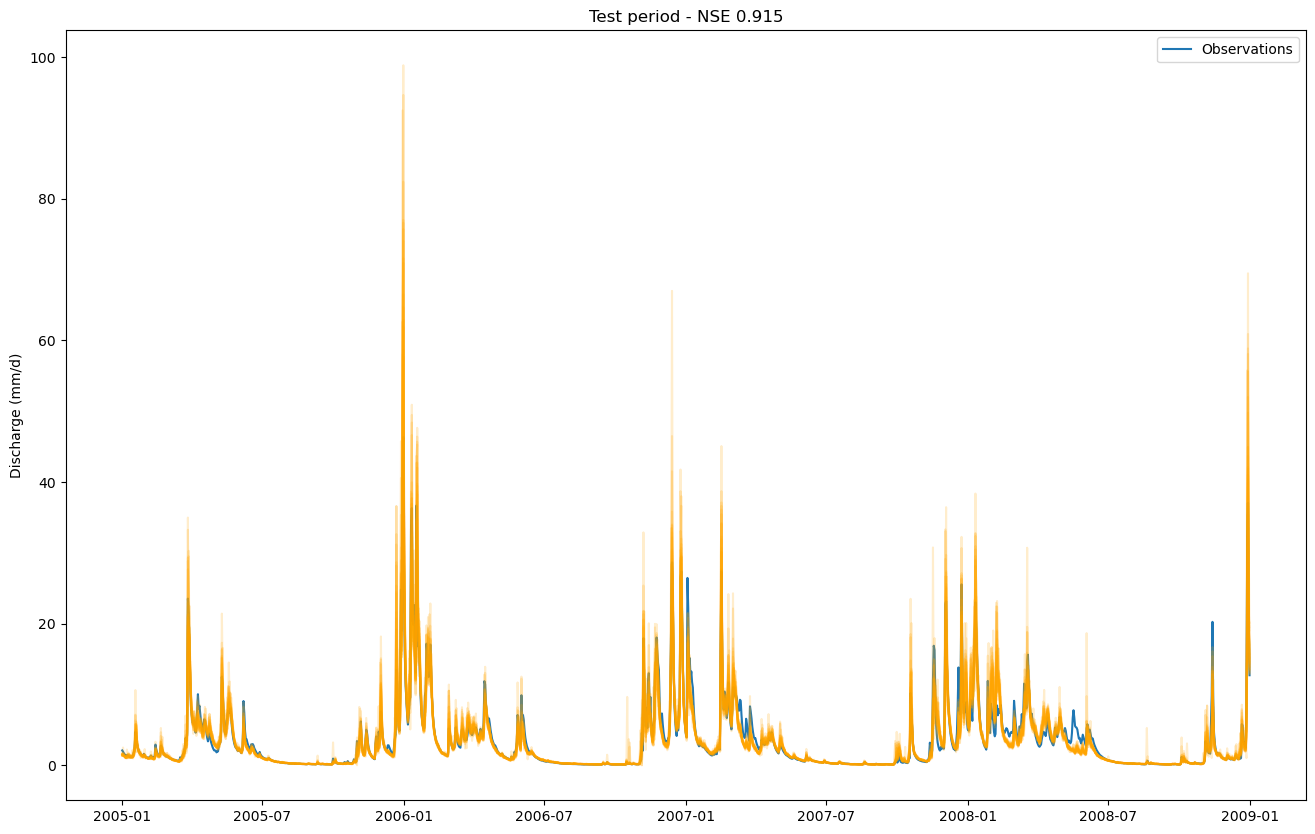

In [29]:
# Extract observations and simulations
qobs = results['14187000']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['14187000']['1D']['xr']['QObs(mm/d)_sim']

# Plot observations
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(qobs['date'], qobs, label='Observations')

# Plot all simulation samples
for i in range(qsim.shape[2]):
    ax.plot(qsim['date'], qsim.isel(samples=i), color='orange', alpha=0.2, label='_nolegend_')  # Plot each sample with low alpha for transparency

ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['14187000']['1D']['NSE']:.3f}")
ax.legend()
plt.show()


In [30]:
# Preprocess result before evaluation
qsim_pi = qsim.values.swapaxes(0, 2).squeeze()
qobs_pi = qobs.values.squeeze()

In [31]:
# Evaluation metrics for probabilistic forecasting
metrics.calculate_all_metrics_prob(qobs_pi,qsim_pi,95)

{'PINAW': 0.35743937931432973, 'PICP': 55.71526351813826}

## Evaluate model with different basin (e.g. HUC 18)

In [32]:
# Probabilistic model 1
run_dir = Path("run_cudalstm_gmm_model")
eval_run(run_dir=run_dir, period="test")

# Evaluation: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]


### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [33]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['10258000', '10258500', '10259000', '10259200', '10263500', '11098000', '11124500', '11141280', '11143000', '11148900', '11151300', '11162500', '11176400', '11180500', '11180960', '11224500', '11230500', '11237500', '11253310', '11264500', '11266500', '11274500', '11274630', '11284400', '11299600', '11381500', '11383500', '11451100', '11468500', '11473900', '11475560', '11476600', '11478500', '11480390', '11481200', '11482500', '11522500', '11523200', '11528700', '11532500'])

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [34]:
# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results.keys():
    # For each dataset in the dictionary
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    dataset['QObs(mm/d)_sim_mean'] = dataset['QObs(mm/d)_sim'].mean(dim='samples')
    dataset['QObs(mm/d)_sim_median'] = dataset['QObs(mm/d)_sim'].median(dim='samples')
    # Select data up to and including 31st December 2008
    results[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

In [35]:
# Calculate all metrics for each basin using mean and median results of probabilistic forecasting
for key in results.keys():
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    
    # Extract observed data
    qobs = dataset['QObs(mm/d)_obs'].isel(time_step=-1)
    # Extract mean and median simulated data
    qsim_mean = dataset['QObs(mm/d)_sim_mean'].isel(time_step=-1)
    qsim_median = dataset['QObs(mm/d)_sim_median'].isel(time_step=-1)

    # Calculate metrics for mean simulated data
    mean_metrics = metrics.calculate_all_metrics(qobs, qsim_mean)
    # Store mean metrics in the dictionary
    results[key]['1D']['mean_metrics'] = mean_metrics

    # Calculate metrics for median simulated data
    median_metrics = metrics.calculate_all_metrics(qobs, qsim_median)
    # Store median metrics in the dictionary
    results[key]['1D']['median_metrics'] = median_metrics

In [36]:
from collections import defaultdict

# Initialize dictionaries to store the sum of metrics
sum_mean_metrics = defaultdict(float)
sum_median_metrics = defaultdict(float)
num_basins = len(results)

# Iterate over each key (basin) in results
for key in results.keys():
    # Retrieve mean_metrics and median_metrics directly from the dictionary
    if 'mean_metrics' in results[key]['1D'] and 'median_metrics' in results[key]['1D']:
        mean_metrics = results[key]['1D']['mean_metrics']
        median_metrics = results[key]['1D']['median_metrics']

        # Sum the metrics for each basin
        for metric, value in mean_metrics.items():
            sum_mean_metrics[metric] += value
        for metric, value in median_metrics.items():
            sum_median_metrics[metric] += value

# Calculate the average for mean_metrics and median_metrics
average_mean_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_mean_metrics.items()}
average_median_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_median_metrics.items()}

In [37]:
# Print the average metrics
print("Average of Mean-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_mean_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

print("\nAverage of Median-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_median_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

Average of Mean-Probf vs One-Point Metrics Across All Basins:
NSE: -26.893
MSE: 14.305
RMSE: 3.547
KGE: -10.917
Alpha-NSE: 1.271
Beta-KGE: 12.606
Beta-NSE: 2.492
Pearson-r: 0.583
FHV: 39.283
FMS: -70.970
FLV: -23705530086.455
Peak-Timing: 0.665
Peak-MAPE: 75.713

Average of Median-Probf vs One-Point Metrics Across All Basins:
NSE: -22.565
MSE: 13.457
RMSE: 3.449
KGE: -9.488
Alpha-NSE: 1.341
Beta-KGE: 11.150
Beta-NSE: 2.212
Pearson-r: 0.566
FHV: 49.436
FMS: -73.214
FLV: -61658293050.600
Peak-Timing: 0.698
Peak-MAPE: 70.495


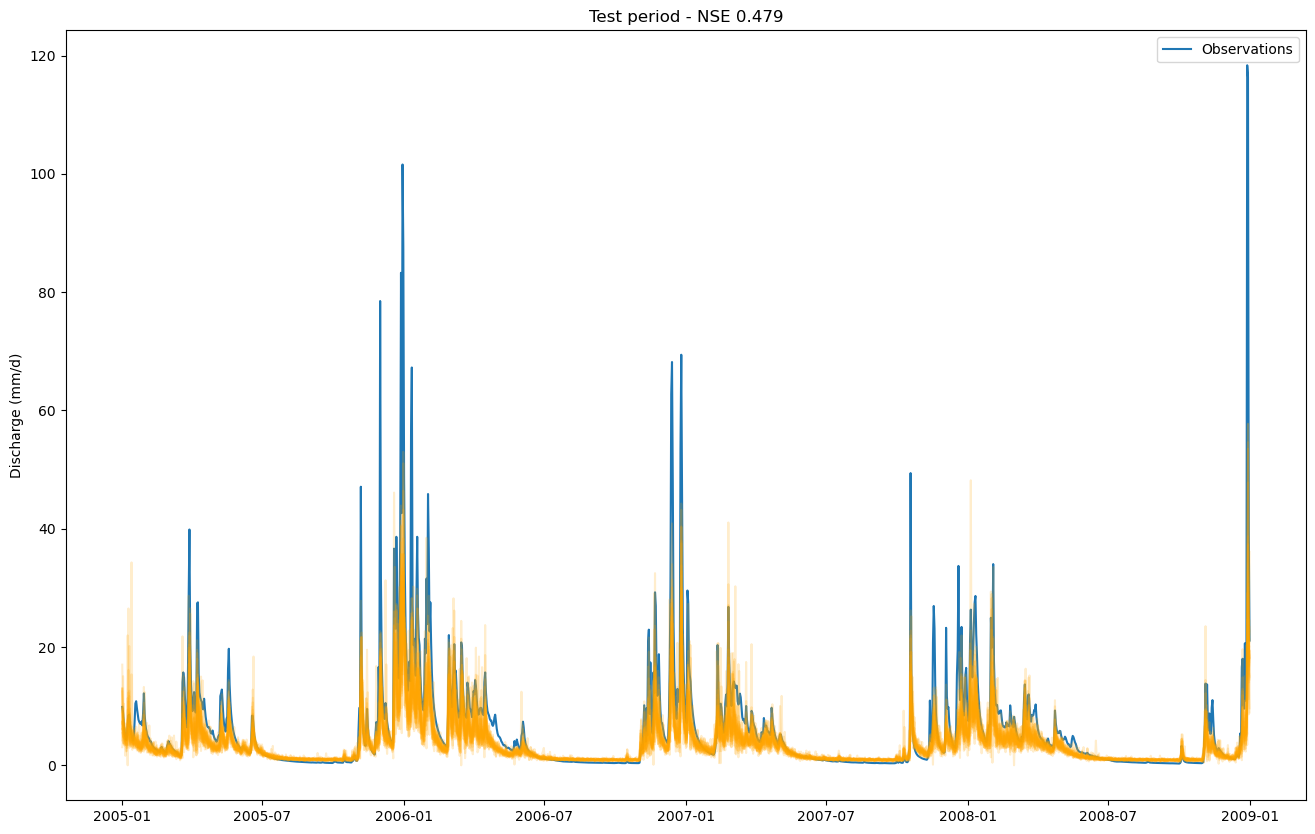

In [38]:
# Extract observations and simulations
qobs = results['11532500']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['11532500']['1D']['xr']['QObs(mm/d)_sim']

# Plot observations
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(qobs['date'], qobs, label='Observations')

# Plot all simulation samples
for i in range(qsim.shape[2]):
    ax.plot(qsim['date'], qsim.isel(samples=i), color='orange', alpha=0.2, label='_nolegend_')  # Plot each sample with low alpha for transparency

ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['11532500']['1D']['NSE']:.3f}")
ax.legend()
plt.show()


In [ ]:
percentile_plot(qobs.values[0:50], qsim[0:50])

In [39]:
# Preprocess result before evaluation
qsim_pi = qsim.values.swapaxes(0, 2).squeeze()
qobs_pi = qobs.values.squeeze()

In [40]:
# Evaluation metrics for probabilistic forecasting
metrics.calculate_all_metrics_prob(qobs_pi,qsim_pi,95)

{'PINAW': 0.3516196006439404, 'PICP': 39.082819986310746}

In [42]:
# Probabilistic model 2
run_dir2 = Path("run_cudalstm_gmm_model_250")
eval_run(run_dir=run_dir2, period="test")

# Evaluation: 100%|████████████████████████████████████████████████████████████████████| 40/40 [00:28<00:00,  1.40it/s]


In [43]:
with open(run_dir2 / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['10258000', '10258500', '10259000', '10259200', '10263500', '11098000', '11124500', '11141280', '11143000', '11148900', '11151300', '11162500', '11176400', '11180500', '11180960', '11224500', '11230500', '11237500', '11253310', '11264500', '11266500', '11274500', '11274630', '11284400', '11299600', '11381500', '11383500', '11451100', '11468500', '11473900', '11475560', '11476600', '11478500', '11480390', '11481200', '11482500', '11522500', '11523200', '11528700', '11532500'])

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [44]:
# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results.keys():
    # For each dataset in the dictionary
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    dataset['QObs(mm/d)_sim_mean'] = dataset['QObs(mm/d)_sim'].mean(dim='samples')
    dataset['QObs(mm/d)_sim_median'] = dataset['QObs(mm/d)_sim'].median(dim='samples')
    # Select data up to and including 31st December 2008
    results[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

In [45]:
# Calculate all metrics for each basin using mean and median results of probabilistic forecasting
for key in results.keys():
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    
    # Extract observed data
    qobs = dataset['QObs(mm/d)_obs'].isel(time_step=-1)
    # Extract mean and median simulated data
    qsim_mean = dataset['QObs(mm/d)_sim_mean'].isel(time_step=-1)
    qsim_median = dataset['QObs(mm/d)_sim_median'].isel(time_step=-1)

    # Calculate metrics for mean simulated data
    mean_metrics = metrics.calculate_all_metrics(qobs, qsim_mean)
    # Store mean metrics in the dictionary
    results[key]['1D']['mean_metrics'] = mean_metrics

    # Calculate metrics for median simulated data
    median_metrics = metrics.calculate_all_metrics(qobs, qsim_median)
    # Store median metrics in the dictionary
    results[key]['1D']['median_metrics'] = median_metrics

In [46]:
from collections import defaultdict

# Initialize dictionaries to store the sum of metrics
sum_mean_metrics = defaultdict(float)
sum_median_metrics = defaultdict(float)
num_basins = len(results)

# Iterate over each key (basin) in results
for key in results.keys():
    # Retrieve mean_metrics and median_metrics directly from the dictionary
    if 'mean_metrics' in results[key]['1D'] and 'median_metrics' in results[key]['1D']:
        mean_metrics = results[key]['1D']['mean_metrics']
        median_metrics = results[key]['1D']['median_metrics']

        # Sum the metrics for each basin
        for metric, value in mean_metrics.items():
            sum_mean_metrics[metric] += value
        for metric, value in median_metrics.items():
            sum_median_metrics[metric] += value

# Calculate the average for mean_metrics and median_metrics
average_mean_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_mean_metrics.items()}
average_median_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_median_metrics.items()}

In [47]:
# Print the average metrics
print("Average of Mean-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_mean_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

print("\nAverage of Median-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_median_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

Average of Mean-Probf vs One-Point Metrics Across All Basins:
NSE: 0.328
MSE: 5.835
RMSE: 2.078
KGE: -0.095
Alpha-NSE: 0.514
Beta-KGE: 1.325
Beta-NSE: 0.022
Pearson-r: 0.681
FHV: -47.284
FMS: -54.893
FLV: -45420909523.429
Peak-Timing: 0.824
Peak-MAPE: 69.691

Average of Median-Probf vs One-Point Metrics Across All Basins:
NSE: 0.371
MSE: 5.897
RMSE: 2.085
KGE: 0.023
Alpha-NSE: 0.459
Beta-KGE: 1.148
Beta-NSE: -0.013
Pearson-r: 0.690
FHV: -53.279
FMS: -56.775
FLV: -45412269122.737
Peak-Timing: 0.811
Peak-MAPE: 71.714


Let's plot the model predictions vs. the observations

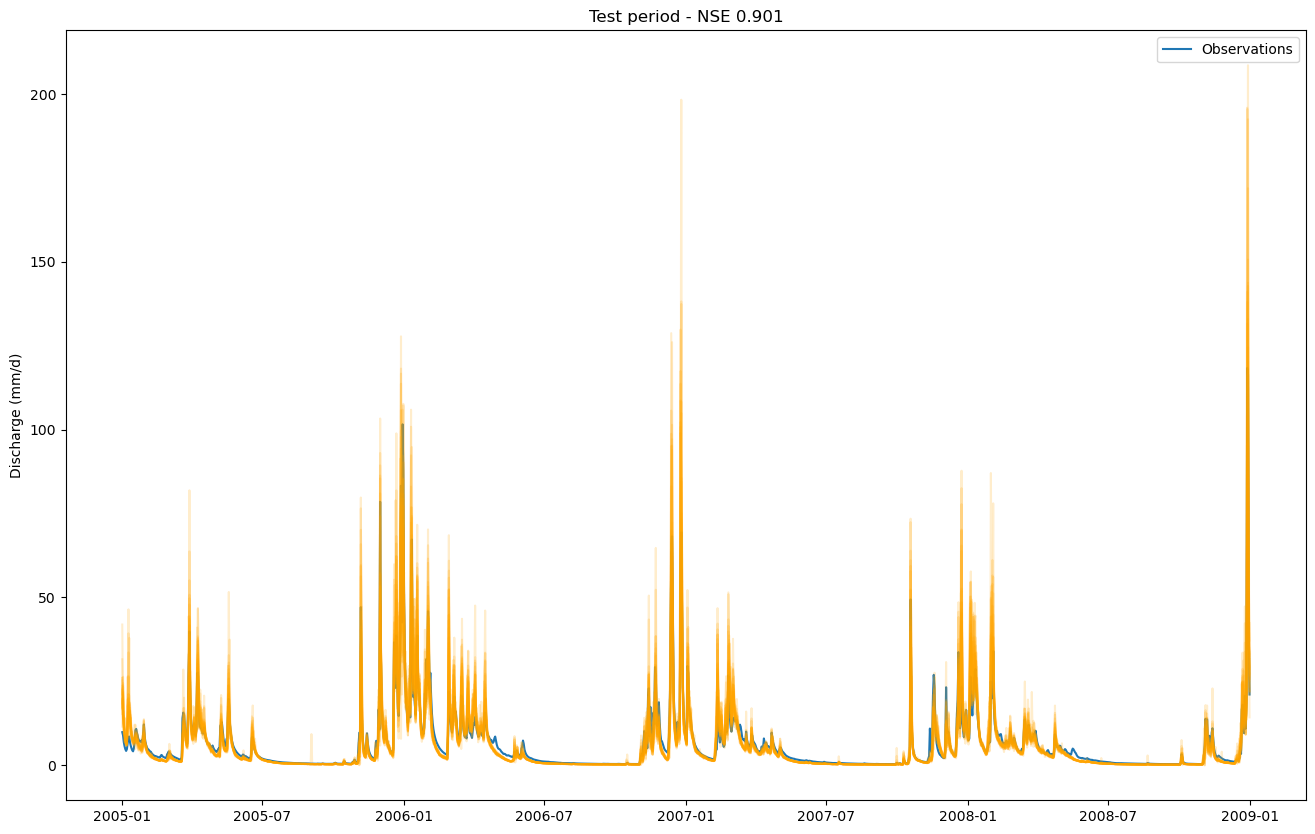

In [49]:
# Extract observations and simulations
qobs = results['11532500']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['11532500']['1D']['xr']['QObs(mm/d)_sim']

# Plot observations
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(qobs['date'], qobs, label='Observations')

# Plot all simulation samples
for i in range(qsim.shape[2]):
    ax.plot(qsim['date'], qsim.isel(samples=i), color='orange', alpha=0.2, label='_nolegend_')  # Plot each sample with low alpha for transparency

ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['11532500']['1D']['NSE']:.3f}")
ax.legend()
plt.show()


In [50]:
# Preprocess result before evaluation
qsim_pi = qsim.values.swapaxes(0, 2).squeeze()
qobs_pi = qobs.values.squeeze()

In [51]:
# Evaluation metrics for probabilistic forecasting
metrics.calculate_all_metrics_prob(qobs_pi,qsim_pi,95)

{'PINAW': 0.41074429983824085, 'PICP': 32.4435318275154}

NameError: name 'lb' is not defined

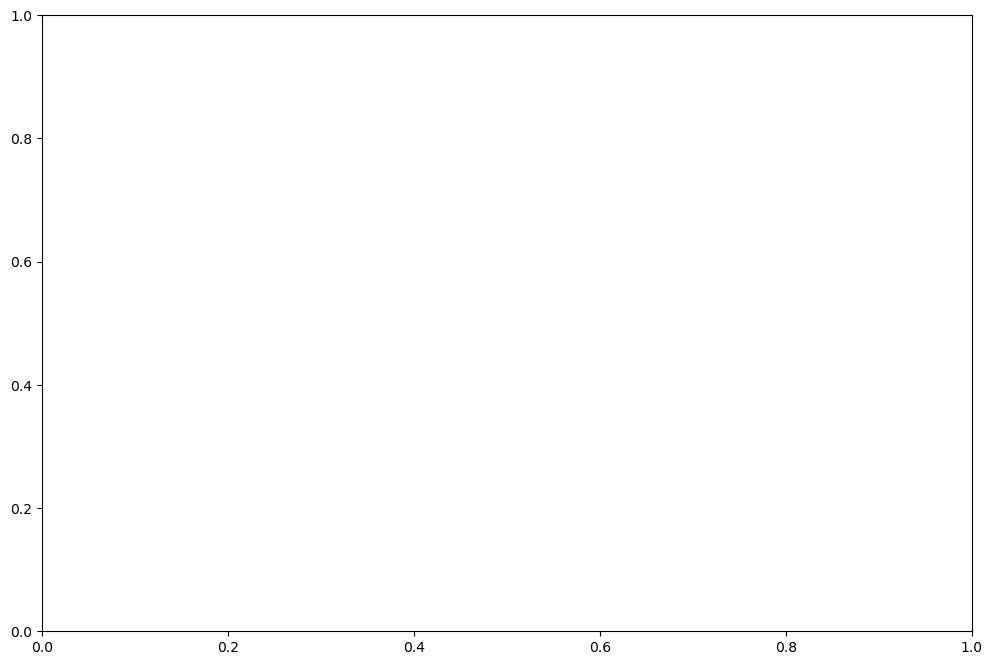

In [41]:
# plt.subplots(figsize=(12,8))
# plt.plot(lb, alpha=0.8)
# plt.plot(ub, alpha=0.8)
# plt.plot(qobs.values)

# time = np.arange(0, len(qobs.values), 1)

# # Create a plot
# for i in range(len(qobs.values)):
#     if (qobs.values[i] >= np.array(lb[i])) and (qobs.values[i] <= np.array(ub[i])):
#         plt.plot(time[i], -10, marker='o',color='blue')
#     else:
#         plt.plot(time[i], -20, marker='x',color='red')

# plt.xlabel('Time')
# plt.ylabel('Observed Values')
# plt.title('Time Series with Observed Values, Lower Bound, and Upper Bound')
# plt.show()


In [5]:
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log file
log_file = "run_cudalstm_base_model/events.out.tfevents.1706112437.e1d7ec1aec98.115659.0"

# Initialize an Event Accumulator
ea = event_accumulator.EventAccumulator(log_file, size_guidance={event_accumulator.SCALARS: 0})

# Load the data from the file
ea.Reload()

# Extract and print specific data for average training loss
for entry in ea.Scalars('train/avg_loss'):
    print(f"Epoch: {entry.step}, Avg Training Loss: {entry.value}")


Epoch: 1, Avg Training Loss: 0.0942322388291359
Epoch: 2, Avg Training Loss: 0.07091523706912994
Epoch: 3, Avg Training Loss: 0.06584692001342773
Epoch: 4, Avg Training Loss: 0.06421589106321335
Epoch: 5, Avg Training Loss: 0.06378720700740814
Epoch: 6, Avg Training Loss: 0.06156774237751961
Epoch: 7, Avg Training Loss: 0.06136726960539818
Epoch: 8, Avg Training Loss: 0.06171084940433502
Epoch: 9, Avg Training Loss: 0.059914253652095795
Epoch: 10, Avg Training Loss: 0.05849286913871765
Epoch: 11, Avg Training Loss: 0.05813400447368622
Epoch: 12, Avg Training Loss: 0.058307599276304245
Epoch: 13, Avg Training Loss: 0.057359468191862106
Epoch: 14, Avg Training Loss: 0.058324046432971954
Epoch: 15, Avg Training Loss: 0.05755758285522461
Epoch: 16, Avg Training Loss: 0.05719742923974991
Epoch: 17, Avg Training Loss: 0.05744204670190811
Epoch: 18, Avg Training Loss: 0.05671452358365059
Epoch: 19, Avg Training Loss: 0.05634021386504173
Epoch: 20, Avg Training Loss: 0.056853532791137695
Epoch

In [7]:
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log file
log_file = "run_cudalstm_base_model/events.out.tfevents.1706112437.e1d7ec1aec98.115659.0"

# Initialize an Event Accumulator
ea = event_accumulator.EventAccumulator(log_file, size_guidance={event_accumulator.SCALARS: 0})

# Load the data from the file
ea.Reload()

# Extract and print specific data for average validation loss
for entry in ea.Scalars('valid/avg_loss'):
    print(f"Epoch: {entry.step}, Avg Validation Loss: {entry.value}")


Epoch: 3, Avg Validation Loss: 0.07049562782049179
Epoch: 6, Avg Validation Loss: 0.06626491993665695
Epoch: 9, Avg Validation Loss: 0.06418365240097046
Epoch: 12, Avg Validation Loss: 0.06533167511224747
Epoch: 15, Avg Validation Loss: 0.06326641887426376
Epoch: 18, Avg Validation Loss: 0.06422656029462814
Epoch: 21, Avg Validation Loss: 0.06748383492231369
Epoch: 24, Avg Validation Loss: 0.06755928695201874
Epoch: 27, Avg Validation Loss: 0.06402097642421722
Epoch: 30, Avg Validation Loss: 0.061017099767923355
Epoch: 33, Avg Validation Loss: 0.05716916173696518
Epoch: 36, Avg Validation Loss: 0.06286109238862991
Epoch: 39, Avg Validation Loss: 0.06039975583553314
Epoch: 42, Avg Validation Loss: 0.05909835547208786
Epoch: 45, Avg Validation Loss: 0.057641055434942245
Epoch: 48, Avg Validation Loss: 0.05984308198094368


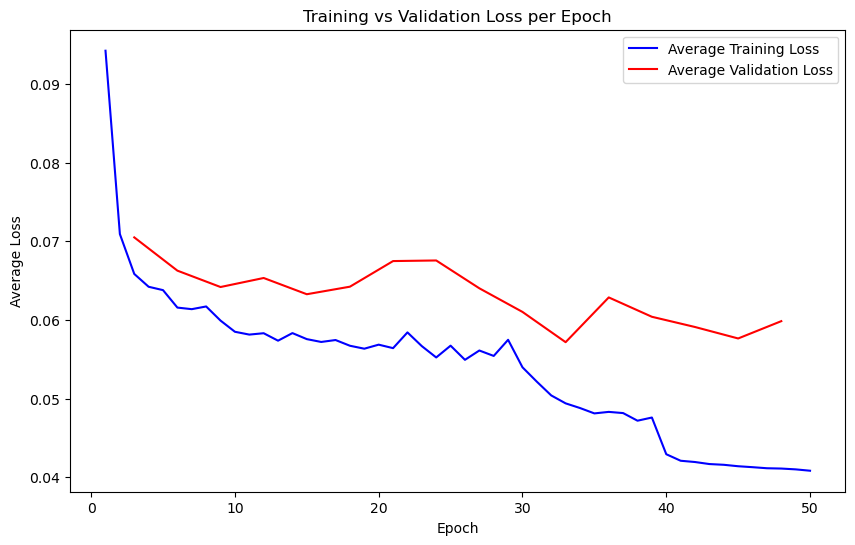

In [10]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log file
log_file = "run_cudalstm_base_model/events.out.tfevents.1706112437.e1d7ec1aec98.115659.0"

# Initialize an Event Accumulator
ea = event_accumulator.EventAccumulator(log_file, size_guidance={event_accumulator.SCALARS: 0})

# Load the data from the file
ea.Reload()

# Extract data for average training and validation loss
epochs_train, values_train = [], []
for entry in ea.Scalars('train/avg_loss'):
    epochs_train.append(entry.step)
    values_train.append(entry.value)

epochs_valid, values_valid = [], []
for entry in ea.Scalars('valid/avg_loss'):
    epochs_valid.append(entry.step)
    values_valid.append(entry.value)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_train, values_train, label='Average Training Loss', color='blue')
plt.plot(epochs_valid, values_valid, label='Average Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training vs Validation Loss per Epoch')
plt.legend()
plt.show()


## Evaluate run on test set (LSTM base model vs MCD)
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [2]:
# Deterministic model 1
run_dir = Path("run_cudalstm_base_model")
eval_run(run_dir=run_dir, period="test")

# Evaluation: 100%|████████████████████████████████████████████████████████████████████| 91/91 [00:34<00:00,  2.64it/s]


### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [3]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['10396000', '12010000', '12013500', '12020000', '12025000', '12025700', '12035000', '12040500', '12041200', '12043000', '12048000', '12054000', '12056500', '12073500', '12082500', '12092000', '12095000', '12114500', '12115000', '12115500', '12117000', '12141300', '12143600', '12144000', '12145500', '12147500', '12147600', '12167000', '12175500', '12178100', '12186000', '12189500', '12358500', '12374250', '12375900', '12377150', '12381400', '12383500', '12388400', '12390700', '12411000', '12414500', '12447390', '12451000', '12488500', '13011500', '13011900', '13018300', '13023000', '13083000', '13161500', '13235000', '13240000', '13310700', '13313000', '13331500', '13337000', '13338500', '13340000', '13340600', '14020000', '14092750', '14096850', '14137000', '14138800', '14138870', '14138900', '14139800', '14141500', '14154500', '14158500', '14158790', '14166500', '14182500', '14185000', '14185900', '14187000', '14216500', '14222500', '14236200', '14301000', '14303200', '1430

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

Text(0.5, 1.0, 'Test period - NSE 0.899')

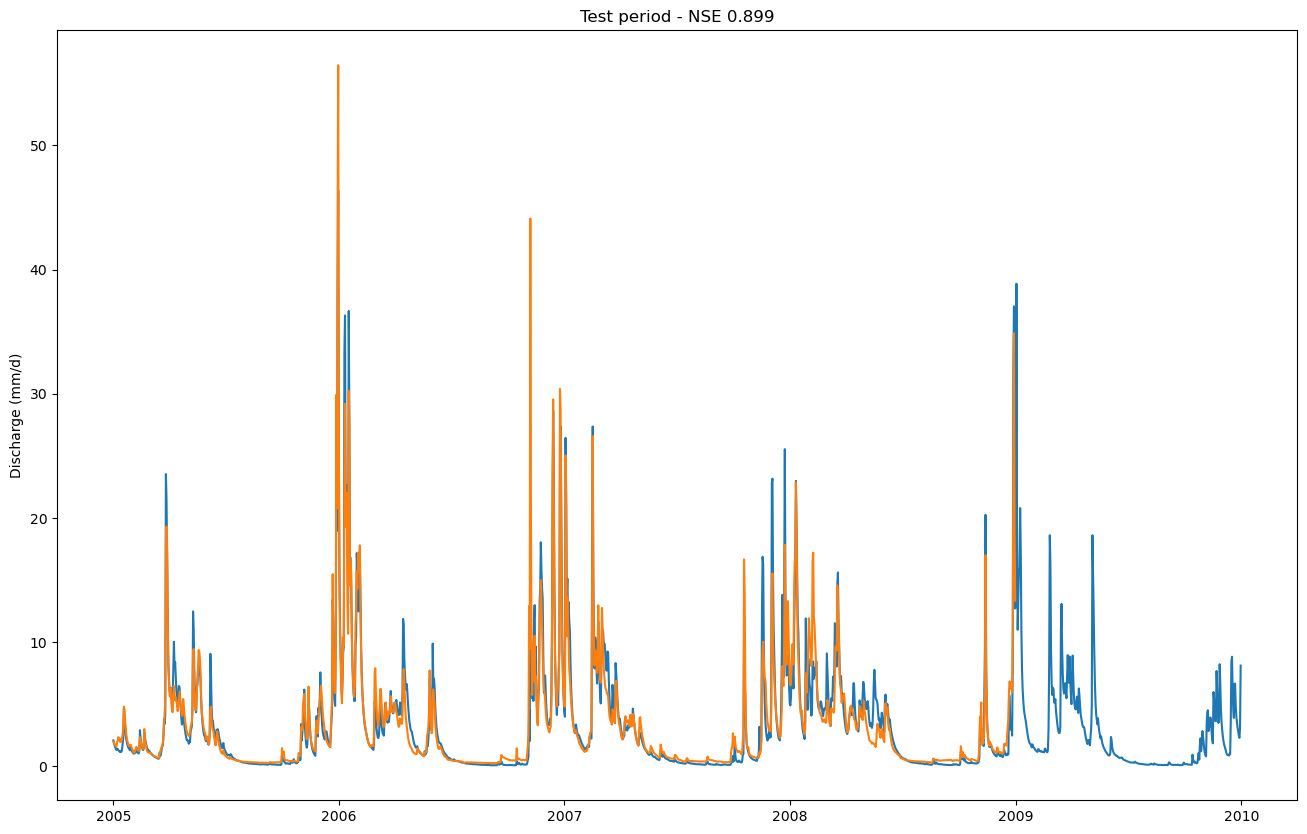

In [6]:
# extract observations and simulations
qobs = results['14187000']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['14187000']['1D']['xr']['QObs(mm/d)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['14187000']['1D']['NSE']:.3f}")

In [7]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

NSE: 0.899
MSE: 2.472
RMSE: 1.572
KGE: 0.944
Alpha-NSE: 0.978
Beta-KGE: 0.995
Beta-NSE: -0.004
Pearson-r: 0.948
FHV: -0.945
FMS: -15.955
FLV: 28.652
Peak-Timing: 0.833
Peak-MAPE: 29.131


In [24]:
# Probabilistic model 2
run_dir2 = Path("run_cudalstm_mcd_model")
eval_run(run_dir=run_dir2, period="test")

# Evaluation:   2%|█▌                                                                   | 2/91 [00:24<18:24, 12.40s/it]


KeyboardInterrupt: 

In [16]:
with open(run_dir2 / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['10396000', '12010000', '12013500', '12020000', '12025000', '12025700', '12035000', '12040500', '12041200', '12043000', '12048000', '12054000', '12056500', '12073500', '12082500', '12092000', '12095000', '12114500', '12115000', '12115500', '12117000', '12141300', '12143600', '12144000', '12145500', '12147500', '12147600', '12167000', '12175500', '12178100', '12186000', '12189500', '12358500', '12374250', '12375900', '12377150', '12381400', '12383500', '12388400', '12390700', '12411000', '12414500', '12447390', '12451000', '12488500', '13011500', '13011900', '13018300', '13023000', '13083000', '13161500', '13235000', '13240000', '13310700', '13313000', '13331500', '13337000', '13338500', '13340000', '13340600', '14020000', '14092750', '14096850', '14137000', '14138800', '14138870', '14138900', '14139800', '14141500', '14154500', '14158500', '14158790', '14166500', '14182500', '14185000', '14185900', '14187000', '14216500', '14222500', '14236200', '14301000', '14303200', '1430

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [17]:
# Clipping the results time step until 31-12-2008 and add mean and median var per basin
for key in results.keys():
    # For each dataset in the dictionary
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    dataset['QObs(mm/d)_sim_mean'] = dataset['QObs(mm/d)_sim'].mean(dim='samples')
    dataset['QObs(mm/d)_sim_median'] = dataset['QObs(mm/d)_sim'].median(dim='samples')
    # Select data up to and including 31st December 2008
    results[key]['1D']['xr'] = dataset.sel(date=slice(None, '2008-12-31'))

In [18]:
# Calculate all metrics for each basin using mean and median results of probabilistic forecasting
for key in results.keys():
    dataset = results[key]['1D']['xr']  # Adjust this path based on your dict structure
    
    # Extract observed data
    qobs = dataset['QObs(mm/d)_obs'].isel(time_step=-1)
    # Extract mean and median simulated data
    qsim_mean = dataset['QObs(mm/d)_sim_mean'].isel(time_step=-1)
    qsim_median = dataset['QObs(mm/d)_sim_median'].isel(time_step=-1)

    # Calculate metrics for mean simulated data
    mean_metrics = metrics.calculate_all_metrics(qobs, qsim_mean)
    # Store mean metrics in the dictionary
    results[key]['1D']['mean_metrics'] = mean_metrics

    # Calculate metrics for median simulated data
    median_metrics = metrics.calculate_all_metrics(qobs, qsim_median)
    # Store median metrics in the dictionary
    results[key]['1D']['median_metrics'] = median_metrics

In [19]:
from collections import defaultdict

# Initialize dictionaries to store the sum of metrics
sum_mean_metrics = defaultdict(float)
sum_median_metrics = defaultdict(float)
num_basins = len(results)

# Iterate over each key (basin) in results
for key in results.keys():
    # Retrieve mean_metrics and median_metrics directly from the dictionary
    if 'mean_metrics' in results[key]['1D'] and 'median_metrics' in results[key]['1D']:
        mean_metrics = results[key]['1D']['mean_metrics']
        median_metrics = results[key]['1D']['median_metrics']

        # Sum the metrics for each basin
        for metric, value in mean_metrics.items():
            sum_mean_metrics[metric] += value
        for metric, value in median_metrics.items():
            sum_median_metrics[metric] += value

# Calculate the average for mean_metrics and median_metrics
average_mean_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_mean_metrics.items()}
average_median_metrics = {metric: sum_val / num_basins for metric, sum_val in sum_median_metrics.items()}

In [20]:
# Print the average metrics
print("Average of Mean-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_mean_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

print("\nAverage of Median-Probf vs One-Point Metrics Across All Basins:")
for metric, avg_val in average_median_metrics.items():
    print(f"{metric}: {avg_val:.3f}")

Average of Mean-Probf vs One-Point Metrics Across All Basins:
NSE: 0.693
MSE: 9.047
RMSE: 2.353
KGE: 0.713
Alpha-NSE: 0.886
Beta-KGE: 1.126
Beta-NSE: 0.097
Pearson-r: 0.894
FHV: -11.493
FMS: -19.461
FLV: -78.722
Peak-Timing: 0.499
Peak-MAPE: 33.378

Average of Median-Probf vs One-Point Metrics Across All Basins:
NSE: 0.716
MSE: 9.088
RMSE: 2.357
KGE: 0.744
Alpha-NSE: 0.908
Beta-KGE: 1.089
Beta-NSE: 0.071
Pearson-r: 0.890
FHV: -11.015
FMS: -14.527
FLV: -1168.436
Peak-Timing: 0.492
Peak-MAPE: 33.853


Let's plot the model predictions vs. the observations

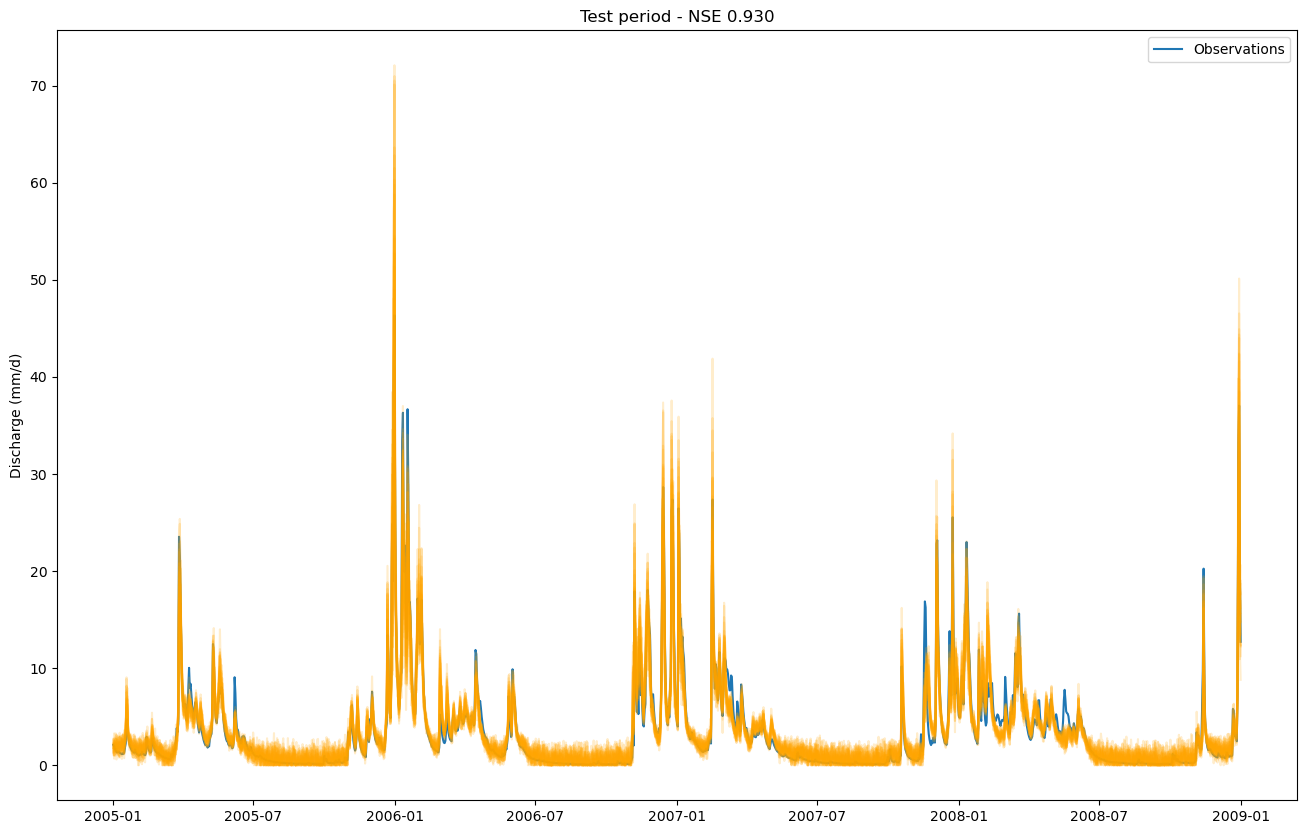

In [21]:
# Extract observations and simulations
qobs = results['14187000']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['14187000']['1D']['xr']['QObs(mm/d)_sim']

# Plot observations
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(qobs['date'], qobs, label='Observations')

# Plot all simulation samples
for i in range(qsim.shape[2]):
    ax.plot(qsim['date'], qsim.isel(samples=i), color='orange', alpha=0.2, label='_nolegend_')  # Plot each sample with low alpha for transparency

ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['14187000']['1D']['NSE']:.3f}")
ax.legend()
plt.show()


In [22]:
# Preprocess result before evaluation
qsim_pi = qsim.values.swapaxes(0, 2).squeeze()
qobs_pi = qobs.values.squeeze()

In [23]:
# Evaluation metrics for probabilistic forecasting
metrics.calculate_all_metrics_prob(qobs_pi,qsim_pi,95)

{'PINAW': 0.4964583914759971, 'PICP': 80.62970568104039}

## Evaluate model with different basin (e.g. HUC 18)